In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import math
import pandas as pd

In [2]:
import scipy.io

keys = ['names', 'images', 'drawings', 'offsets']

def load_mat(file):
	mat = scipy.io.loadmat(file)
	return mat

mat_dict = load_mat("./data_background.mat")

names = []
for i in range(len(mat_dict['names'])):
	names.append(str(mat_dict['names'][i].tolist()[0][0]))

character = {}
for index, (name, drawings_dir, images_dir) in enumerate(zip(names, mat_dict['drawings'], mat_dict['images'])):

	drawings_dir, images_dir = drawings_dir[0], images_dir[0]

	_dir = []
	for drawings_subdir, images_subdir in zip(drawings_dir, images_dir):
		drawings_subdir, images_subdir = drawings_subdir[0], images_subdir[0]
		_subdir = []
		for drawings_img, images_img in zip(drawings_subdir, images_subdir):
			idrawings_img, images_img = drawings_img[0], images_img[0]

			_img = {}
			_img['data'] = images_img
			_img['strokes'] = []
			for drawings_stroke in zip(drawings_img):
				_img['strokes'].append(drawings_stroke[0])
			_subdir.append(_img)
		_dir.append(_subdir)

	character[name] = _dir

In [3]:
print(len(character['Braille'][8][1]['strokes'][0][8][0]))

25


In [4]:
# primitives = character[<language>][<character>][<character number>]['strokes'][0][<primitive number>][0] --> (n,2) np array

In [5]:
character['Hebrew'][8][1]['strokes'][0][2].shape

(1,)

In [6]:
x=character['Hebrew'][8][1]['strokes'][0][2][0][:,[0]]
y=character['Hebrew'][8][1]['strokes'][0][2][0][:,[1]]
print(x.shape,y.shape)

(53, 1) (53, 1)


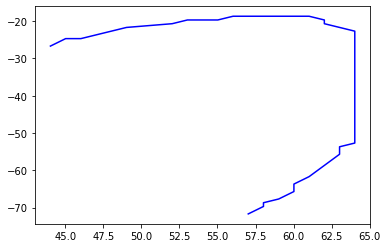

In [7]:
plt.plot(x,y,'b')
plt.show()

In [8]:
from rdp import rdp

In [9]:
mask = rdp(character['Hebrew'][8][1]['strokes'][0][2][0],epsilon=1,algo="iter",return_mask=False)

In [10]:
mask.shape[0]

7

In [11]:
character['Hebrew'][8][1]['strokes'][0][2][0].shape

(53, 2)

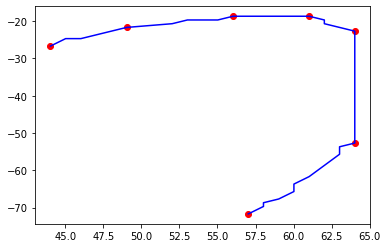

In [12]:
plt.plot(mask[:,[0]],mask[:,[1]],'ro')
plt.plot(x,y,'b')
plt.show()

In [13]:
# rdp takes a (n,2) input, so I make a function and 
# iterate it until it gives me a 5 point representation of the spline.

In [14]:
def spline(prim):
    """
    Args:
        prim (np array): Numpy array of points in dimension (n,2), in the format (x,y).
        
    Return:
        Numpy array (spline) of dimension (5,2).
    """
    mask = rdp(prim,algo="iter",return_mask=False)
    ep=0
    while mask.shape[0]!=5 :
        ep+=0.1
        mask=rdp(prim,epsilon=ep,algo="iter",return_mask=False)
    return mask

In [15]:
sp=spline(character['Hebrew'][8][1]['strokes'][0][2][0])

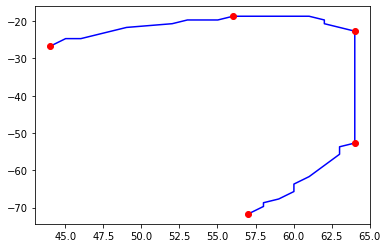

In [16]:
plt.plot(x,y,'b')
plt.plot(sp[:,[0]],sp[:,[1]],'ro')

In [17]:
from scipy import interpolate

In [18]:
print(x.reshape(-1).shape,y.reshape(-1).shape)

(53,) (53,)


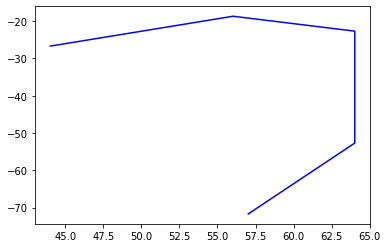

In [19]:
# plt.plot(out1[0],out1[1],'r')
plt.plot(sp[:,[0]],sp[:,[1]],'b')
plt.show()

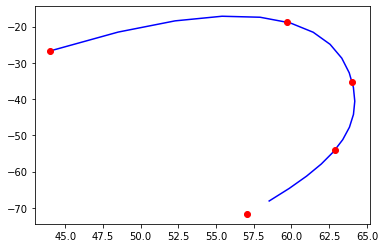

In [20]:
# Method 1
tck, u = interpolate.splprep([x.reshape(-1), y.reshape(-1)], s=0) #
unew = np.arange(0,1.1,0.25) #
out = interpolate.splev(unew, tck)#
xn, yn = out[0], out[1] #
tck, u = interpolate.splprep([xn, yn], s=0)
unew2 = np.arange(0,1,0.05)
out2 = interpolate.splev(unew2, tck)
plt.plot(out2[0],out2[1],'b')
plt.plot(xn,yn,'ro')
plt.show()

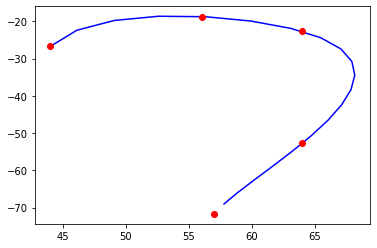

In [21]:
# Method 2
xn, yn = sp[:, 0], sp[:, 1]
tck, u = interpolate.splprep([xn, yn], s=0)
unew2 = np.arange(0,1,0.05)
out2 = interpolate.splev(unew2, tck)
plt.plot(out2[0],out2[1],'b')
plt.plot(xn,yn,'ro')
plt.show()

In [22]:
# I will use method 1, as recommended by Shashi.
# Storing the primitives as 5-point splines for each and every character in the dataset.
# primitives = character[<language>][<character>][<character number>]['strokes'][0][<primitive number>][0] --> (n,2) np array

# Store in the form of primitives = prims[<language>][<character>][<char number>]['strokes'][<primitive number>] --> (5,2) np array

In [23]:
np.random.normal(0,0.5,(5,1))

array([[ 0.24848655],
       [-0.64643383],
       [-0.64005269],
       [ 0.01826258],
       [ 0.04276882]])

In [59]:
def rep(arr):
    last=arr[-1].reshape(-1,1)
    for _ in range(5-arr.shape[0]):
        arr=np.append(arr,last,axis=0)
    return arr
def spline_5(primitive):
    """
    Args:
        primitive (numpy array): The (n,2) np array of the primitive coordinates.
    """
    xc=primitive[:,[0]]
    yc=primitive[:,[1]]
    d=xc.shape[0]
    try :
        if d>=5:
            tck, u = interpolate.splprep([xc.reshape(-1), yc.reshape(-1)], s=0)
            unew = np.arange(0,1.1,0.25)
            out = interpolate.splev(unew, tck)

            ## Comment out below 4 lines for outputting the spline
            xn, yn = out[0], out[1]
            tck, u = interpolate.splprep([xn, yn], s=0)
            unew2 = np.arange(0,1,0.05)
            out = interpolate.splev(unew2, tck)

            return np.array(out).transpose((1,0))
        else :
            if d==1:
                return np.concatenate((rep(xc),rep(yc)),axis=1)
            tck, u = interpolate.splprep([xc.reshape(-1), yc.reshape(-1)], s=0,k=1)
            unew = np.arange(0,1.1,0.25)
            out = interpolate.splev(unew, tck)
            return np.array(out).transpose((1,0))
    except :
        xc+=np.random.normal(0,0.5,(d,1))
        yc+=np.random.normal(0,0.5,(d,1))
        return spline_5(np.concatenate((xc,yc),axis=1))

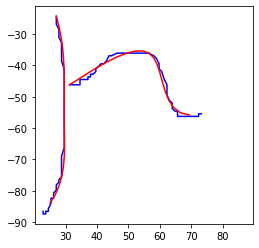

In [101]:
xm=character['Early Aramaic'][17][2]['strokes'][0]
ym=character['Early Aramaic'][17][2]['strokes'][0]
plt.plot(xm[0][0][:,[0]],ym[0][0][:,[1]],'b')
plt.plot(xm[1][0][:,[0]],ym[1][0][:,[1]],'b')
# plt.plot(xm[2][0][:,[0]],ym[2][0][:,[1]],'b')
# plt.plot(xm[3][0][:,[0]],ym[3][0][:,[1]],'b')
plt.plot(spline_5(np.concatenate((xm[0][0][:,[0]],ym[0][0][:,[1]]),axis=1))[:,[0]],spline_5(np.concatenate((xm[0][0][:,[0]],ym[0][0][:,[1]]),axis=1))[:,[1]],'r')
plt.plot(spline_5(np.concatenate((xm[1][0][:,[0]],ym[1][0][:,[1]]),axis=1))[:,[0]],spline_5(np.concatenate((xm[1][0][:,[0]],ym[1][0][:,[1]]),axis=1))[:,[1]],'r')
# plt.plot(spline_5(np.concatenate((xm[2][0][:,[0]],ym[2][0][:,[1]]),axis=1))[:,[0]],spline_5(np.concatenate((xm[2][0][:,[0]],ym[2][0][:,[1]]),axis=1))[:,[1]],'r')
# plt.plot(spline_5(np.concatenate((xm[3][0][:,[0]],ym[3][0][:,[1]]),axis=1))[:,[0]],spline_5(np.concatenate((xm[3][0][:,[0]],ym[3][0][:,[1]]),axis=1))[:,[1]],'r')
plt.axis('square')
plt.show()

In [51]:
prims={} # Initialized an empty dict first
type(prims)

dict

In [ ]:
# primitives = character[<language>][<character>][<character number>]['strokes'][0][<primitive number>][0] --> (n,2) np array
for language in character:
    for char in character[language]:
        for char_num in char:
            # char_num is a dict with key 'strokes'
            for prim_num in char_num['strokes'][0]:
                spline=spline_5(prim_num[0])